## RWS VAE

In [1]:
import inspect
import os

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
from jax import jit
from jax import lax
from jax import random
from jax.example_libraries import stax
from jax.random import PRNGKey
from numpyro import optim
from numpyro.examples.datasets import MNIST
from numpyro.examples.datasets import load_dataset
from tensorflow_probability.substrates import jax as tfp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata


import genjax
from genjax import grasp
from genjax import gensp
from genjax import select

import adevjax

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
# sns.set_theme(style="white")
# font_path = (
#     "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
# )
# font_manager.fontManager.addfont(font_path)
# custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
# rcParams["font.family"] = custom_font_name
# rcParams["figure.autolayout"] = True
label_fontsize = 70  # Set the desired font size here


def show_image(img):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(img, cmap="gray_r")


def save_images(imgs, path):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")
    #fig.savefig(path, format="pdf")

pytree_mean = lambda pytree: jtu.tree_map(lambda v: v.mean(axis=0), pytree)


hidden_dim = 400
z_dim = 10
learning_rate = 1.0e-3
batch_size = 64
num_epochs = 50 # 100
num_particles = 5

/opt/conda/envs/grasp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loss figure.
# loss_fig, loss_ax = plt.subplots(figsize=(8, 8))
# loss_ax.set_xlim(0, 205)
# loss_ax.set_ylim(-117.0, -95.0)
# loss_ax.set_xlabel("Epoch steps", fontsize=label_fontsize / 2)
# loss_ax.set_ylabel("ELBO", fontsize=label_fontsize / 2)
# loss_ax.axhline(y=-115.0, color="red", linestyle="--", lw=4)
# loss_ax.axhline(y=-98.0, color="green", linestyle="--", lw=4)
# loss_ax.text(
#     275,
#     -115.5,
#     "-155.0 (nat)",
#     color="red",
#     va="bottom",
#     ha="right",
#     fontsize=label_fontsize / 3,
# )
# loss_ax.text(
#     270,
#     -98.5,
#     "-98.0 (nat)",
#     color="green",
#     va="bottom",
#     ha="right",
#     fontsize=label_fontsize / 3,
# )
# loss_ax.set_xticks([])
# loss_ax.set_yticks([])
# loss_ax.yaxis.labelpad = 18  # adjust the value as needed

# iwae_iters = [2, 5, 10, 20]
# colormap = plt.cm.magma
# colors = colormap(np.linspace(0, 1, 1 + 2 * len(iwae_iters)))

In [3]:
def encoder(hidden_dim, z_dim): # q
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()),
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp),
        ),
    )

def decoder(hidden_dim, out_dim): # p
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.Dense(out_dim, W_init=stax.randn()),
    )

In [4]:
encoder_nn_init, encoder_nn_apply = encoder(hidden_dim, z_dim)
decoder_nn_init, decoder_nn_apply = decoder(hidden_dim, 28 * 28)

# Model + guide close over the neural net apply functions.
@genjax.gen
def model(decoder_params):
    latent = genjax.tfp_mv_normal_diag(jnp.zeros(z_dim), jnp.ones(z_dim)) @ "latent"
    logits = decoder_nn_apply(decoder_params, latent)
    _ = genjax.tfp_bernoulli(logits) @ "image"


@genjax.gen
def guide(encoder_params, chm):
    image = chm["image"]
    μ, Σ_scale = encoder_nn_apply(encoder_params, image)
    _ = grasp.mv_normal_diag_reparam(μ, Σ_scale) @ "latent"


In [5]:
# ##### Begin bug reproduction
# rng_key = PRNGKey(0)
# encoder_init_key, decoder_init_key = random.split(rng_key)
# _, encoder_params = encoder_nn_init(encoder_init_key, (784,))
# _, decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
# trs = jax.vmap(model.simulate, in_axes=(0, None))(jax.random.split(PRNGKey(0), 13), (decoder_params,))
# imgs = jax.lax.map(lambda tr: tr.strip()['image'], trs)
# def image_loss(key, img):
#     data_chm =genjax.choice_map({'image': img})
#     posterior_approx = grasp.sir(num_particles, guide, (encoder_params, data_chm))
#     tgt = genjax.gensp.target(model, (decoder_params,), data_chm)
#     @adevjax.adev
#     def integrand(p_params, q_params):
#         key = adevjax.reap_key()
#         _, sample = posterior_approx.simulate(key, tgt)
#         key = adevjax.reap_key()
#         return -guide.assess(key, sample.value, (encoder_params, data_chm))[1]
#     return adevjax.E(integrand).value_and_grad_estimate(key, (decoder_params, encoder_params))[0]

# batched_loss = jax.vmap(image_loss)
# batched_loss(jax.random.split(PRNGKey(0), 13), imgs);
# ##### End bug reproduction

In [6]:
def rws_p_wake(
    p, p_params,
    q, q_params,
    nparticles,
    data_chm,
):
    posterior_approx = grasp.sir(nparticles, q, (q_params, data_chm))
    tgt = genjax.gensp.target(p, (p_params,), data_chm)
    @adevjax.adev
    def integrand(p_params, q_params):
        key = adevjax.reap_key()
        _, sample = posterior_approx.simulate(key, tgt)
        key = adevjax.reap_key()
        return -p.assess(key, sample.value, (p_params,))[1]

    return adevjax.E(integrand)

In [7]:
def rws_q_wake(
    p, p_params,
    q, q_params,
    nparticles,
    data_chm,
):
    posterior_approx = grasp.sir(nparticles, q, (q_params, data_chm))
    tgt = genjax.gensp.target(p, (p_params,), data_chm)
    @adevjax.adev
    def integrand(p_params, q_params):
        key = adevjax.reap_key()
        _, sample = posterior_approx.simulate(key, tgt)
        key = adevjax.reap_key()
        return -q.assess(key, sample.value, (q_params, data_chm))[1]

    return adevjax.E(integrand)

In [8]:
def rws_q_sleep(
    p, p_params,
    q, q_params,
    nparticles,
    _,
):
    p_sampler = lambda key: p.simulate(key, (p_params,)).strip()
    @adevjax.adev
    def integrand(p_params, q_params):
        key = adevjax.reap_key()
        sample = p_sampler(key)
        data_chm = genjax.choice_map({"image": sample['image']})
        q_chm = genjax.choice_map({"latent": sample['latent']})
        key = adevjax.reap_key()
        return -q.assess(key, q_chm, (q_params, data_chm))[1]

    return adevjax.E(integrand)

In [9]:
def make_batch_updater(
    p, # model
    q, # guide
    num_particles,
    optimizer,
):
    def rws_step(key, loss_factory, opt_state, batch):
        def loss_and_grad(key, data, p_params, q_params):
            data_chm = genjax.choice_map({"image": data.reshape((28 * 28,))})
            grasp_loss =  loss_factory(p, p_params, q, q_params, num_particles, data_chm)
            loss, (p_grad, q_grad) = grasp_loss.value_and_grad_estimate(key, (p_params, q_params))
            return loss, p_grad, q_grad
        subkeys = jax.random.split(key, len(batch))
        p_params, q_params = optimizer.get_params(opt_state)
        batched_loss_and_grad = jax.vmap(loss_and_grad, in_axes=(0, 0, None, None))
        losses, p_grads, q_grads = batched_loss_and_grad(subkeys, batch, p_params, q_params)
        p_grad, q_grad = pytree_mean((p_grads, q_grads))
        opt_state = optimizer.update((p_grad, q_grad), opt_state)
        return opt_state, losses.mean()
        
    def batch_updater(key, opt_state, batch):
        losses = []
        for (i, loss_factory) in enumerate((rws_p_wake, rws_q_wake, rws_q_sleep)):
            subkey = jax.random.fold_in(key, idx)
            opt_state, loss = rws_step(subkey, loss_factory, opt_state, batch)
            losses.append(loss)
        return opt_state, losses

    return batch_updater

In [10]:
sgd = optim.SGD(learning_rate)
batch_updater = make_batch_updater(model, guide, num_particles, sgd)
train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
num_train, train_idx = train_init()
rng_key = PRNGKey(0)
encoder_init_key, decoder_init_key = random.split(rng_key)
_, encoder_params = encoder_nn_init(encoder_init_key, (784,))
_, decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
num_train, train_idx = train_init()

In [11]:
#@jit
def binarize(rng_key, batch):
    return random.bernoulli(rng_key, batch).astype(batch.dtype)

#@jit
def epoch_train(opt_state, key1, key2, train_idx):
    def body_fn(carry, xs):
        idx, opt_state = carry
        rng_key_binarize = random.fold_in(key1, idx)
        batch = binarize(rng_key_binarize, train_fetch(idx, train_idx)[0])
        updater_key = random.fold_in(key2, idx)
        opt_state, losses = batch_updater(updater_key, opt_state, batch)
        idx += 1
        return (idx, opt_state), losses

    (_, opt_state), losses = lax.scan(
        body_fn, (0, opt_state), None, length=num_train
    )
    return opt_state, losses


# Train.
key = random.PRNGKey(314159)
opt_state = sgd.init((decoder_params, encoder_params))
epoch_losses = []
for idx in range(0, num_epochs):
    key, key1, key2 = jax.random.split(key, 3)
    num_train, train_idx = train_init()
    opt_state, losses = epoch_train(opt_state, key1, key2, train_idx)
    mean_losses =  pytree_mean(losses)
    print('epoch {} p_wake={:.5} q_wake={:.5} q_sleep={:.5}'.format(idx, *mean_losses))
    epoch_losses.append(mean_losses)

epoch 0 p_wake=231.59 q_wake=14.225 q_sleep=14.214
epoch 1 p_wake=221.06 q_wake=14.213 q_sleep=14.221
epoch 2 p_wake=220.72 q_wake=14.199 q_sleep=14.208
epoch 3 p_wake=220.58 q_wake=14.221 q_sleep=14.22
epoch 4 p_wake=220.47 q_wake=14.209 q_sleep=14.199
epoch 5 p_wake=220.49 q_wake=14.221 q_sleep=14.212
epoch 6 p_wake=220.41 q_wake=14.222 q_sleep=14.208
epoch 7 p_wake=220.39 q_wake=14.234 q_sleep=14.22
epoch 8 p_wake=220.34 q_wake=14.25 q_sleep=14.224
epoch 9 p_wake=220.26 q_wake=14.259 q_sleep=14.222
epoch 10 p_wake=220.17 q_wake=14.25 q_sleep=14.208
epoch 11 p_wake=220.07 q_wake=14.282 q_sleep=14.221
epoch 12 p_wake=219.82 q_wake=14.252 q_sleep=14.198
epoch 13 p_wake=219.31 q_wake=14.256 q_sleep=14.188
epoch 14 p_wake=218.09 q_wake=14.21 q_sleep=14.136
epoch 15 p_wake=214.03 q_wake=14.02 q_sleep=13.98
epoch 16 p_wake=209.23 q_wake=13.747 q_sleep=13.773
epoch 17 p_wake=208.33 q_wake=13.704 q_sleep=13.735
epoch 18 p_wake=207.95 q_wake=13.719 q_sleep=13.764
epoch 19 p_wake=207.54 q_wake

In [12]:
# loss_ax.scatter(
#     jnp.arange(num_epochs),
#     jnp.array([l[0] for l in epoch_losses]),
#     color=colors[0],
#     marker=".",
#     label="ELBO",
#     s=240,
# )
# loss_fig

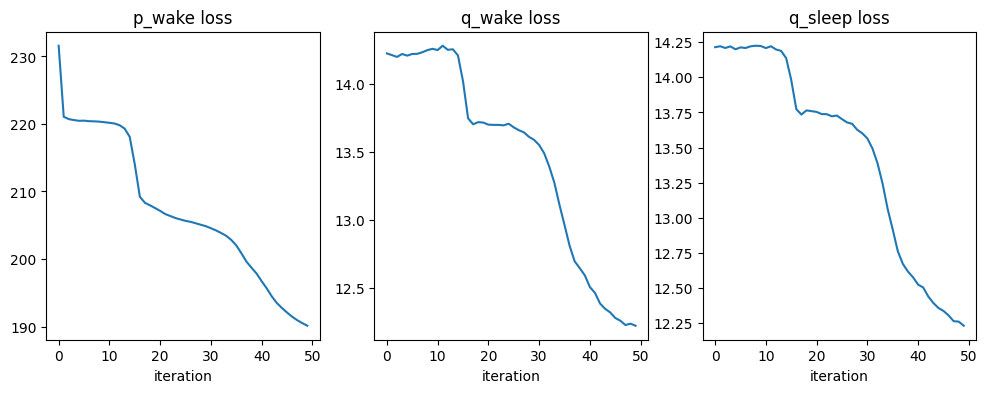

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for (i, (ax, title)) in enumerate(zip(axs, ('p_wake', 'q_wake', 'q_sleep'))):
    ax.plot([l[i] for l in epoch_losses])
    ax.set_xlabel('iteration')
    ax.set_title(title + ' loss')

In [13]:
def generate_images(key, n_images, opt_state):
    images = []
    for i in range(0, n_images):
        key, sub_key = jax.random.split(key)
        updated_decoder_params, _ = sgd.get_params(opt_state)
        latent = genjax.tfp_mv_normal_diag.sample(
            key, jnp.zeros(z_dim), jnp.ones(z_dim)
        )
        updated_out = jax.nn.sigmoid(
            decoder_nn_apply(updated_decoder_params, latent)
        ).reshape(28, 28)
        images.append(updated_out)
    return images

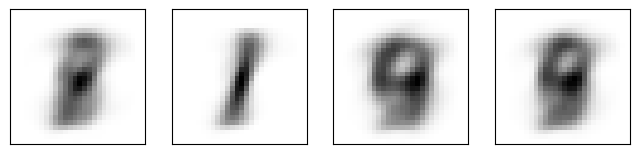

In [14]:
sub_key = jax.random.PRNGKey(314159)
imgs = generate_images(sub_key, 4, opt_state)
save_images(imgs, "img/elbo_samples.pdf")